## Import libraries

In [1]:
import gym
import numpy as np
import random
from matplotlib import pyplot as plt
from collections import deque
import xgboost as xgb
from sklearn.model_selection import train_test_split, KFold, cross_val_score
import itertools

## Initialize class
Class is initialized with 4 XGBRegressor models, one for each state feature, and one XGBClassifier model.
Training data is collected in state-action pairs. 
Each XGBRegressor model is fit using the training data with one timestep offset, so for a given model current state feature is predicted by previous state-action.
A custom reward function is used where selected state feature closest to zero is given highest reward - in this case the pole angle is used as selected state feature for the custom reward function.
Action at current state is selected based on predicted state at timestep t+n with the highest reward.

On a successfully completed episode data is passed to the XGBClassifier to be trained. A "switch" variable is used to gradually, after each successful epsidode, hand over the action selection to this second layer. 


In [2]:
class XGBAgent(object):

    def __init__(self, ma_training_data_size, mb_training_data_size, ma_mb_switch):

        self.env = gym.make("CartPole-v0")

        self.action_space = self.env.action_space.n
        self.observation_space_n = self.env.observation_space.shape[0]

        self.model_a_params = {
            'learning_rate':0.05
            , 'colsample_bytree':1
            , 'objective':'reg:linear'
            , 'n_estimators':1000
            , 'max_depth':10
        }

        self.model_a = [xgb.XGBRegressor(**self.model_a_params) 
                        for model in range(self.observation_space_n)]

        self.model_b_params = {
            'learning_rate':0.05
            , 'colsample_bytree':0.7
            , 'objective':'binary:logistic'
            , 'n_estimators':1000
            , 'max_depth':10
        }

        self.model_b = xgb.XGBClassifier(**self.model_b_params)

        self.model_b_validation_score = 0

        self.model_a_features = [
            [0,1,2,3,4]
            , [1,4]
            , [2,3,4]
            , [3,4]
        ]
        
        self.model_a_data_columns = ['Level', 'Sid', 'Pid', 'State', 'Action']

        self.rewarded_features = [[2, 1]]
        self.action_index = 4
        self.episode_index = 5

        self.training_data = deque(maxlen=ma_training_data_size)
        self.training_data_b = deque(maxlen=mb_training_data_size)
        
        self.steps = 0
        self.episodes = 0

        self.ma_mb_switch = ma_mb_switch

    def fit_model_a(self):

        for idx, m in enumerate(self.model_a):
            
            X, Y = [], []
            for e in range(self.episodes):
                
                X_append = [x[self.model_a_features[idx]] for x in self.training_data if x[self.episode_index] == e][:-1]
                for x in X_append: X.append(x)
                
                y_append = [y[idx] for y in self.training_data if y[self.episode_index] == e][1:]
                for y in y_append: Y.append(y)
            
            X, Y = np.array(X), np.array(Y)

            X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25)

            self.model_a[idx].fit(
                X_train, y_train
                , early_stopping_rounds=50
                , eval_set=[(X_test, y_test)]
                , eval_metric='rmse'
                , verbose=False)

    def fit_model_b(self):
        
        if self.model_b_validation_score >= 0.96: return

        X, Y = [], []

        for row in self.training_data_b:
            X.append(row[:self.action_index])
            Y.append(row[self.action_index])

        X, Y = np.array(X), np.array(Y)

        if len(self.training_data_b) < self.training_data_b.maxlen:
            self.model_b.fit(X, Y)
        else:
            kfold = KFold(n_splits=5)
            results = cross_val_score(self.model_b, X, Y, cv=kfold)
            if results.mean() > self.model_b_validation_score:
                self.model_b.fit(X, Y)
                self.model_b_validation_score = results.mean()

    def adjust_ma_mb_switch(self, ma_mb_switch_factor, ma_mb_switch_minimum, ma_mb_switch):
        self.ma_mb_switch = max(self.ma_mb_switch * ma_mb_switch_factor, ma_mb_switch_minimum)

    def transfer_data_to_model_b(self, mb_threshold_for_model_fit):
        batch = list(itertools.islice(self.training_data, len(self.training_data)-mb_threshold_for_model_fit, len(self.training_data)))
        for row in batch: self.training_data_b.append(row)
 
    def receive_custom_reward(self, state):
        reward = 0
        for feature in self.rewarded_features:
            reward += 1 - min(((state[feature[0]])**2)**0.5, 1)
            reward *= feature[1]
        return reward

    def run_episode(self, test=False, ma_prediction_timesteps=2):

        terminal_state = None
        episode_steps = 0
        state = self.env.reset()
        
        while True:
            
            action = random.randrange(self.action_space) 

            if test:

                if self.ma_mb_switch > np.random.rand():
                
                    level = 0
                    sid = 0
                    pid = 0
                    best_reward = 0

                    data = [dict(zip(
                                self.model_a_data_columns
                                , [level, sid, None, state, None]))]

                    while level < ma_prediction_timesteps:

                        states = [row['State'] for row in data if row['Level'] == level]
                        level += 1

                        for s in states:
                            for a in range(self.action_space):

                                predicted_state = []

                                for idx, m in enumerate(self.model_a):

                                    x_state = np.append(np.array(s).copy(), a)
                                    x_state = x_state[self.model_a_features[idx]]

                                    predicted_state_feature = self.model_a[idx].predict([x_state])[0]
                                    predicted_state.append(predicted_state_feature)

                                sid += 1
                                
                                data.append(
                                    dict(zip(
                                        self.model_a_data_columns
                                        , [level, sid, pid, np.array(predicted_state), a])))

                            pid += 1
                    
                    leaf_states = [{'Pid': row['Pid'], 'State': row['State']}
                                    for row in data if row['Level'] == level]
                    
                    rewards = np.array([self.receive_custom_reward(row['State']) 
                                for row in leaf_states])
                    
                    best_reward_idx = np.random.choice(np.flatnonzero(rewards == rewards.max()))

                    pid_search = leaf_states[best_reward_idx]
                    
                    while level > 1:
                        level -= 1
                        pid_state = [row for row in data if row['Sid'] == pid_search['Pid']][0]
                        pid_search = pid_state.copy()
                    action = pid_state['Action']

                else:

                    action = np.int(self.model_b.predict([state])[0])
            
            next_state, _, done, _ = self.env.step(action)

            if done:
                terminal_state = state
                break

            episode_steps += 1

            row = np.append(np.append(state, action), np.array([self.episodes]))

            self.training_data.append(row)

            state = next_state
        
        self.steps += episode_steps
        self.episodes += 1

        return episode_steps, terminal_state 

## Set hyperparameters

In [3]:
MA_TRAINING_DATA_SIZE = 800
MA_PREDICTION_TIMESTEPS = 2

MB_TRAINING_DATA_SIZE = 2200
MB_THRESHOLD_FOR_MODEL_FIT = 195

MA_MB_SWITCH = 1
MA_MB_SWITCH_MINIMUM = 0
MA_MB_SWITCH_FACTOR = 0.8

MAXIMUM_EPISODES = 500
EPISODES_TO_SOLVE = 100

## Run main

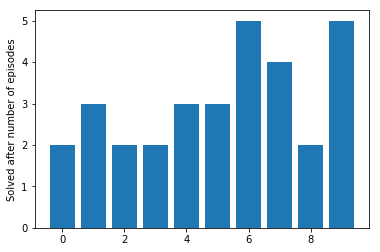

Solved on average after 3.1 episodes


In [4]:
if __name__ == "__main__":

    solved_envs = []
    for _ in range(10):
        
        episode_list = []

        xgba = XGBAgent(MA_TRAINING_DATA_SIZE, MB_TRAINING_DATA_SIZE, MA_MB_SWITCH)
        
        episode_steps = xgba.run_episode(test=False, ma_prediction_timesteps=0)

        while True:

            xgba.fit_model_a()
            episode_steps, terminal_state = xgba.run_episode(test=True, ma_prediction_timesteps=MA_PREDICTION_TIMESTEPS)
            episode_list.append(episode_steps)

            if episode_steps >= MB_THRESHOLD_FOR_MODEL_FIT:
                xgba.transfer_data_to_model_b(MB_THRESHOLD_FOR_MODEL_FIT)
                xgba.adjust_ma_mb_switch(MA_MB_SWITCH_FACTOR, MA_MB_SWITCH_MINIMUM, MA_MB_SWITCH)
                xgba.fit_model_b()
            else:
                pass
                #print(xgba.episodes , episode_steps, xgba.ma_mb_switch, 'ts:', terminal_state)
  
            if len(episode_list) > EPISODES_TO_SOLVE:

                if np.mean(episode_list[-EPISODES_TO_SOLVE:]) >= 195.0:
                    
                    #print ('Solved after', xgba.episodes-EPISODES_TO_SOLVE, 'episodes')
                    solved_envs.append(xgba.episodes-EPISODES_TO_SOLVE)
                    break

            if xgba.episodes > MAXIMUM_EPISODES:
                print('Not solved!')
                solved_envs.append(MAXIMUM_EPISODES)
                break
    
    plt.bar([idx for idx, x in enumerate(solved_envs)],solved_envs)
    plt.ylabel('Solved after number of episodes')
    plt.show()
    
    print('Solved on average after',np.mean(solved_envs),'episodes')
    #xgba.env.close()